# Loading Data & Packages

In [1]:
try:
    del Twt_cleaner
except:
    pass 
import Twt_cleaner

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
#KenJi's NLP
from difflib import SequenceMatcher
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
tqdm.pandas()
#MingLun's Text Cleanning mod
from TextCleaner import TextCleaner
from nltk.sentiment import SentimentIntensityAnalyzer # VADEdR


In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
df_raw = pd.read_csv('Bitcoin_tweets.csv')

C:\Users\18066\AppData\Local\Temp/ipykernel_52380/76465128.py:1: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('Bitcoin_tweets.csv')


In [7]:
# sample_fraction = 20
# _sample_size = int(df_raw.shape[0]/sample_fraction)
# df_sample = df_raw.sample(_sample_size)
df_sample = df_raw.copy()

In [8]:
df_sample.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups, posts are not the view of my employer, RTs are not endorsements, military brat, @UNC alumnus, ΚΑΨ♦️ΦΝΠ, -DW = Me",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #bitcoin ATM announcement https://t.co/xaaZmaJKiV @MyBlueRidgeBank… https://t.co/sgBxMkP1SI,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at informing the general public about crypto & technology! 😉 AND promoting it: https://t.co/5RYdRnUSud,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""🎬 Take 2"" with our friend @LeoWandersleb, #Btc #wallet #security expe… https://t.co/go6aDgRml5","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, #Cryptocurrency trading education platform: https://t.co/LUr56q3Q19 🙋‍♂️ 💰 💰in the World 🗺..",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about BTC and would like to share with you all - https://t.co/QxCZgmuy3B… https://t.co/o6wn7ppkVY",NaN,Twitter Web App,False
3,Crypto is the future,NaN,"I will post a lot of buying signals for BTC trading, so I hope that you block me. Drop all everything, Buy Bitcoin for the future I was together with you!",2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \4872644.0 (2021/02/11 08:51) #Bitcoin #FX #BTC #crypto,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,"Co-founder @RENJERJerky | Forbes 30Under30 | Innovation Economist, Lateral Thinker, Futurist, #Crypto-enthusiast, facts over ideology! \n#Bitcoin",2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,"This network is secured by 9 508 nodes as of today. Soon, the biggest bears will recognise: #BTC in too big to fail… https://t.co/1XovDA8rKw",['BTC'],Twitter Web App,False


# Goal1:Identify Bots

In [13]:
#Cleaning the varified variable 
True_idx = list(df_sample.query("user_verified == True").index)
True_idx +=  list(df_sample.query("user_verified == 'True'").index)
try:
    df_sample.insert(0,'user_verified_clean',0)
except ValueError:
    pass 
for idx in True_idx:
    df_sample.at[idx,'user_verified_clean'] = 1

## Kenji's Algo #1

In [15]:
def Get_likeness_score(df,n=5):
    #KenJi's Algo1
    df['og_index'] = df.index
    #Step1:Store all Non-varified user and their texts
    by_user = df.query('user_verified_clean == 0').groupby('user_name').agg({'text' : lambda x : list(x),'og_index':lambda x : list(x)}) 
    #Step2:Id those who has more than n posts
    by_user_more5 = by_user[by_user['text'].str.len() > n]
    #Step3:Calculate likely ness score from package SequenceMatcher
    all_score = []
    for user_name, v in tqdm(by_user_more5.iterrows(), total = len(by_user_more5)):
        texts = v[0]
        first_text = texts[0]
        scores = []
        for t in texts[1:]:
            scores.append(SequenceMatcher(None, first_text, t).ratio())
        all_score.append(sum(scores)/len(scores))
    by_user_more5['scores'] = all_score
    return by_user_more5

In [ ]:
#df_score_cleaned = Get_likeness_score(df_clean)

In [21]:
df_score_raw = Get_likeness_score(df_sample)

  0%|          | 0/57929 [00:00<?, ?it/s]

C:\Users\18066\AppData\Local\Temp/ipykernel_52380/783988564.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_user_more5['scores'] = all_score


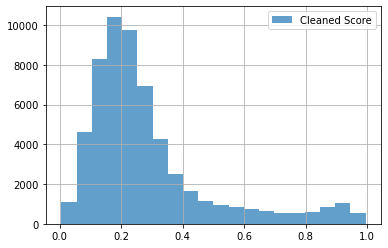

In [22]:
#df_score_cleaned.scores.hist(bins = 20,alpha=0.7)
df_score_raw.scores.hist(bins = 20,alpha=0.7)
plt.legend(['Cleaned Score','Raw Score'])

In [23]:
df_score_raw.query('scores > 0.7').head(2)

,text,og_index,scores
user_name,,,
"""ОбвалОчный"" нОж""Обвальщика""","[🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.1127358259 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.0187893043 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.0031315507 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.0005219251 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, I earned with the help of my friends! 💸 Anyone can try how it is simple and fun on @betfury i-Gaming platform. My Username: User934930 #betfurysuccess #tron #bitcoin #referral, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.0000144979 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 3.221e-7 BFG. My Username: User934930 #betfurysuccess #bitcoin #staking, 🎱Haha! Lucky number in Dice is mine! It was a great win on Betfury in the amount of 0.0000334489 BNB. My Username: User934930 #betfurysuccess #bitcoin #staking]","[1335560, 1341715, 1341827, 1343320, 1343871, 1369039, 1369266, 1399650]",0.891953
#BBTC 🚀,"[@Waves_Exchange 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @BinanceES 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @Rubiu5 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @Hotbit_news @BtcbamG 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @Hotbit_news @peace_tokenfin 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @Hotbit_news @Immutable 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @IbaiLlanos 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @cripto_mi 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11TH - NOVEMBER 17TH 📆\n\nSave the date and we will be even further Known! 🚀 #Bitcoin #BBTC #BTC #BABYBITCOIN #BNB #NY #TIMESQUARE https://t.co/ilDRqVMEdf, @MARCIANOPHONE 🚀 It’s confirmed and official ✅\n\nBaby Bitcoin $BBTC will officially be in Times Square 🤯@BabyBitcoinBSC \n\n📆Date: NOVEMBER 11T

In [24]:
df_agg = df_sample.copy()
df_agg.insert(df_agg.shape[1],'IsBot_1',0)
for row in df_score_raw.query('scores > 0.7').iterrows():
    for index in row[-1][-2]:
        df_agg.at[index,'IsBot_1'] = 1

## KenJi's Algo #2

In [25]:
df_sample.groupby('source').count().sort_values('user_name',ascending=False).head(30)

,user_verified_clean,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,is_retweet,og_index
source,,,,,,,,,,,,,,
Twitter for Android,674912,674897,290973,540305,674912,674912,674912,674912,674912,674912,674912,672130,674912,674912
Twitter Web App,592042,592030,302329,517234,592042,592042,592042,592042,592042,592042,592042,585989,592042,592042
Twitter for iPhone,452024,452020,270511,405226,452024,452024,452024,452024,452024,452024,452024,449690,452024,452024
IFTTT,34394,34394,24824,32706,34394,34394,34394,34394,34394,34394,34394,34056,34394,34394
dlvr.it,28811,28811,15861,28531,28811,28811,28811,28811,28811,28811,28811,28788,28811,28811
ContentStudio.io,20045,20045,19446,19913,20045,20045,20045,20045,20045,20045,20045,19974,20045,20045
TweetDeck,19181,19181,11595,17979,19181,19181,19181,19181,19181,19181,19181,19023,19181,19181
Twitter for iPad,14394,14394,8902,13003,14394,14394,14394,14394,14394,14394,14394,14325,14394,14394
HoBaBot,13137,13137,0,13137,13137,13137,13137,13137,13137,13137,13137,13137,13137,13137


In [26]:
IDX_UD = list(df_sample[[True if i else False for i in df_sample.user_description.str.contains('bot',case = False, na = False)]].index)

IDX_Source_bot = list(df_sample[(df_sample['source'].str.contains('bot', case = False, na = False)) 
            & (df_sample['source'] != 'Tweetbot for iΟS')]['source'].index) #Tweetbot is an app name - not bot

IDX_Source_crypto = list(df_sample[(df_sample['source'].str.contains('crypto', case = False, na = False))]['source'].index) #Tweetbot is an app name - not bot

IDX_Name = list(df_sample[[True if i else False for i in df_sample.user_name.str.contains('bot',case = False, na = False)]].index)

IDX_agg = set(IDX_Name+IDX_UD+IDX_Source_bot+IDX_Source_crypto)

In [27]:
try:
    df_agg.insert(df_agg.shape[1],'IsBot_2',0)
except:
    pass 
for index in IDX_agg:
    df_agg.at[index,'IsBot_2'] = 1

In [28]:
pd.crosstab(df_agg['IsBot_1'],df_agg['IsBot_2'])

IsBot_2,0,1
IsBot_1,,
0,1926398,121092
1,171584,65852


In [31]:
df_agg.to_csv('twt_text_handpicked_bots.csv')

# Clean Data

In [38]:
#Cleaning the urls
DEFAULT_CLEAN_PROCEDURE = (
    ('modify','Lower'),
    ('modify','SimilarWords'),
    ('remove','URL'),
    ('remove','Emoji'),
    ('remove','SpecialCharacters'),
    ('remove','ExtraSpaces'),
    ('remove','BegingEndSpace'),
)
tr = TextCleaner(DEFAULT_CLEAN_PROCEDURE)
print("Original:")
print(df_sample.text.iloc[10])
print("______________________")
tr.clean(df_sample.text.iloc[10]) #Remove url of a given str 

#Clean all the text in the dataframe 
df_clean = df_agg.copy()
for index in tqdm(df_clean.index):
    try:
        df_clean.at[index,'text'] = tr.clean(df_clean.at[index,'text'])
    except:
        print("Error:",df_clean.at[index,'text'])

Original:
Annnd #btc #Bitcoin is headed even higher now... https://t.co/EHAduI087d
______________________


  0%|          | 0/2284926 [00:00<?, ?it/s]

Error: nan
Error: nan


# Part2:Use clustering algorithm to identify the bot clusters

In [40]:
df_clean.to_csv('twt_text_handpicked_bots_Cleaned.csv')

In [42]:
#Vectorize the data
bot_classification = df_agg.copy()
#IsBot_1 == 0 and IsBot_2 == 0
bot_classification['ISbot'] = df_agg.IsBot_1.multiply(df_agg.IsBot_2)
bot_classification = bot_classification.dropna(subset=['text'])
corpus = bot_classification['text'].apply(lambda x : x.split(' '))

0                            [Blue, Ridge, Bank, shares, halted, by, NYSE, after, #bitcoin, ATM, announcement, https://t.co/xaaZmaJKiV, @MyBlueRidgeBank…, https://t.co/sgBxMkP1SI]
1                [😎, Today,, that's, this, #Thursday,, we, will, do, a, "🎬, Take, 2", with, our, friend, @LeoWandersleb,, #Btc, #wallet, #security, expe…, https://t.co/go6aDgRml5]
2                     [Guys, evening,, I, have, read, this, article, about, BTC, and, would, like, to, share, with, you, all, -, https://t.co/QxCZgmuy3B…, https://t.co/o6wn7ppkVY]
3                                                                    [$BTC, A, big, chance, in, a, billion!, Price:, \4872644.0, (2021/02/11, 08:51), #Bitcoin, #FX, #BTC, #crypto]
4             [This, network, is, secured, by, 9, 508, nodes, as, of, today., Soon,, the, biggest, bears, will, recognise:, #BTC, in, too, big, to, fail…, https://t.co/1XovDA8rKw]
                                                                                          ...       

In [56]:
from gensim.models import Word2Vec
count_matrix = Word2Vec(corpus)

In [57]:
w2v_vectors = count_matrix.wv.vectors # here you load vectors for each word in your model
w2v_indices = count_matrix.wv.key_to_index

In [59]:
import numpy as np
def vectorize(line): 
    words = []
    for word in line: # line - iterable, for example list of tokens 
        try:
            w2v_idx = w2v_indices[word]
        except KeyError: # if you does not have a vector for this word in your w2v model, continue 
            continue
        words.append(w2v_vectors[w2v_idx])
        if words: 
            words = np.asarray(words)
            min_vec = words.min(axis=0)
            max_vec = words.max(axis=0)
            return np.concatenate((min_vec, max_vec))
        if not words:
            return None 

bot_classification['text_vec'] = bot_classification['text'].apply(vectorize)

In [66]:
unique_user = bot_classification.drop_duplicates(subset=['user_name'])

In [68]:
user_vectors = pd.DataFrame(unique_user['text_vec'].to_list())

# Dimension Reduction before clustering:

In [78]:
from sklearn.decomposition import PCA
# count_matrix.wv.key_to_index
# vectors = count_matrix.wv.vectors
# words = list(count_matrix.wv.key_to_index)
_dct = {}
for n_components in tqdm(range(1,25)):
    pca = PCA(n_components=n_components)
    PCA_result = pca.fit_transform(user_vectors)
    _dct[n_components] = sum(pca.explained_variance_ratio_) 

  0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Elbow plot to identify appropriate N-compoents')

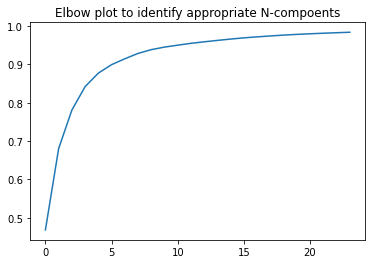

In [80]:
plt.plot(_dct.values())
plt.title('Elbow plot to identify appropriate N-compoents')

In [82]:
pca = PCA(n_components=7)
PCA_result = pca.fit_transform(user_vectors)
sum(pca.explained_variance_ratio_) #0.914% variance was preserved by reducing n_compoents to 7

0.9145533048207486

# Cluster the data

In [83]:
from sklearn.cluster import KMeans

In [85]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(PCA_result)

KMeans(n_clusters=100)

In [96]:
test_cluster = unique_user.copy()
test_cluster['cluster_K'] = kmeans.labels_ #Incorperate results

In [101]:
Cluster_Res = test_cluster[['IsBot_1','IsBot_2','ISbot','cluster_K']].groupby(['cluster_K']).mean().sort_values('ISbot',ascending=False)
Cluster_Res

,IsBot_1,IsBot_2,ISbot
cluster_K,,,
88,0.071429,0.142857,0.035714
36,0.047619,0.063492,0.031746
51,0.076923,0.097902,0.027972
99,0.030120,0.078313,0.024096
85,0.059524,0.071429,0.023810
...,...,...,...
63,0.005102,0.010204,0.000000
28,0.006639,0.012294,0.000000
65,0.013699,0.013699,0.000000


In [149]:
bot_index = Cluster_Res.query('IsBot_2 + IsBot_1> 0.01').index
Cluster_Res.query('IsBot_2 + IsBot_1> 0.01')

,IsBot_1,IsBot_2,ISbot
cluster_K,,,
88,0.071429,0.142857,0.035714
36,0.047619,0.063492,0.031746
51,0.076923,0.097902,0.027972
99,0.030120,0.078313,0.024096
85,0.059524,0.071429,0.023810
...,...,...,...
63,0.005102,0.010204,0.000000
28,0.006639,0.012294,0.000000
65,0.013699,0.013699,0.000000


In [150]:
to_drop = list(test_cluster.query(f'cluster_K in {list(bot_index)}').index) #Drop all rows in the bot_clusters defined above 

In [151]:
to_drop += list(test_cluster.query('IsBot_2 + IsBot_1> 0').index)

In [152]:
df_real_clean = df_clean.drop(set(to_drop))

In [153]:
len(set(to_drop))

370666

In [154]:
df_real_clean.shape

(1914260, 17)

In [155]:
df_raw.shape

(2284926, 13)

# Sentiment Analysis

In [160]:
#Create a new dataframe responsible for sentiment analysis
df_sentiment = df_real_clean.copy()

In [163]:
# creating sentiment analyzer pipe
# import nltk
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# VADER method -- same as papers
# getting compound score (also has positive, negative, neutral scores -- compound is combination/total/overall)

def sentiment_analysis(x):
    try:
        return sia.polarity_scores(x)['compound']
    except:
        print(x)
        return 0

In [164]:
df_sentiment['sentiment'] = df_sentiment['text'].progress_apply(sentiment_analysis)

  0%|          | 0/1914260 [00:00<?, ?it/s]

In [166]:
import datetime 
def DATE(date_str):
    temp = date_str.split('-')
    y = int(temp[0])
    m = int(temp[1])
    d = int(temp[2])
    return datetime.datetime(y,m,d)
def Get_date(STR):
    try:
        return str(DATE(STR.split(' ')[0]).date())
    except:
        print(STR)
        return np.nan
#Group by day and count 
df_sentiment['Day'] = df_sentiment.date.apply(Get_date)

nan
nan


In [167]:
df_sentiment.head()

,user_verified_clean,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,og_index,IsBot_1,IsBot_2,sentiment,Day
9,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups, posts are not the view of my employer, RTs are not endorsements, military brat, @UNC alumnus, ΚΑΨ♦️ΦΝΠ, -DW = Me",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:52:08,tesla s bitcoin investment is revolutionary for crypto but other firms may not do the same just yet jpmorgan,"['bitcoin', 'crypto']",Twitter Web App,False,9,0,0,0.0000,2021-02-10
17,0,Crypto is the future,NaN,"I will post a lot of buying signals for BTC trading, so I hope that you block me. Drop all everything, Buy Bitcoin for the future I was together with you!",2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:47:32,btc a big chance in a million price 4898631 0 2021 02 11 08 45 bitcoin fx btc crypto,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,17,1,0,0.2500,2021-02-10
18,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups, posts are not the view of my employer, RTs are not endorsements, military brat, @UNC alumnus, ΚΑΨ♦️ΦΝΠ, -DW = Me",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:47:13,bitcoin institutional demand accelerates in 2021 says grayscale ceo btc btc crypto cryptocurrency gbtc,"['Bitcoin', 'BTC', 'crypto', 'cryptocurrency']",Twitter Web App,False,18,0,0,-0.1280,2021-02-10
26,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups, posts are not the view of my employer, RTs are not endorsements, military brat, @UNC alumnus, ΚΑΨ♦️ΦΝΠ, -DW = Me",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:44:02,after tesla twitter considers adding bitcoin to its balance sheet says company s cfo,['bitcoin'],Twitter Web App,False,26,0,0,0.0000,2021-02-10
31,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups, posts are not the view of my employer, RTs are not endorsements, military brat, @UNC alumnus, ΚΑΨ♦️ΦΝΠ, -DW = Me",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:40:36,the grayscale bitcoin trust what it is and how it works gbtc digital asset fund btc,"['Bitcoin', 'digital', 'asset', 'fund', 'BTC']",Twitter Web App,False,31,0,0,0.7003,2021-02-10


<AxesSubplot:>

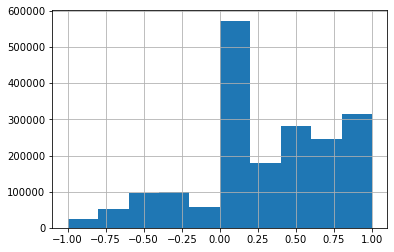

In [177]:
df_sentiment.sentiment.hist()

<AxesSubplot:>

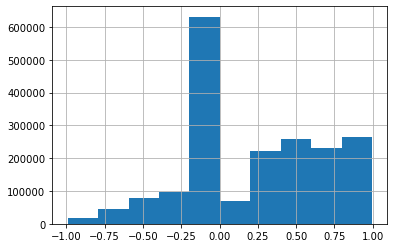

In [168]:
df_sentiment.sentiment.hist()

<AxesSubplot:xlabel='Day'>

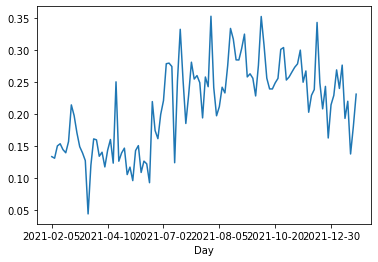

In [169]:
df_sentiment.groupby('Day').sentiment.mean().plot()

In [170]:
df_sentiment.drop('text',axis = 1).to_csv('df_sentiment.csv')